In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
import string
import nltk, re
import pickle
warnings.filterwarnings('ignore')

In [ ]:
# dowload all stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
from nltk.corpus import stopwords

# set of all valid words
dictionary_words = set(nltk.corpus.words.words())

# made set of stopwords
StopWords = set(stopwords.words('english'))
print(StopWords)

{'out', 'too', 'herself', 'by', 'doing', 'off', 'which', 'm', "you'll", 'so', "isn't", 'hadn', 'at', 'yourselves', 'below', 'in', 'once', 'other', 'both', 'these', 'himself', 'where', 'most', 's', 'your', 'haven', "needn't", "shouldn't", 'him', 'needn', 'some', 'being', 'it', 'same', 'any', "doesn't", "weren't", 'not', 'no', 'd', 'ain', "don't", 'only', 'those', "you'd", 'her', 'here', "won't", 'have', 'y', 're', 'didn', 'over', 'you', 'be', 'how', 'aren', 'while', 'she', 'hasn', 'why', 'all', "aren't", "hadn't", "wasn't", 'had', 'of', 'my', 'but', 'if', 'doesn', "it's", "wouldn't", 'until', 'i', 'myself', 'were', 'with', 'hers', "should've", 'above', 'that', 'wasn', "she's", 'down', 'under', 'just', 'up', 'what', 'because', 'its', 'to', 'do', 'mightn', "didn't", 'ourselves', "you're", 'has', 'against', 'will', 'he', 'few', "shan't", "that'll", 'won', 'own', 'o', 'after', 'shan', 'me', 'than', 'into', 'yours', 'are', 'from', 'the', 'am', 'whom', 'shouldn', 'there', 'on', 'further', 'no

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Load the datasets

In [ ]:
# load the dataset
df = pd.read_csv("emotion_tweet.csv", encoding="UTF8")

# check the shape of dataframe
print(df.shape)

(10017, 4)


In [ ]:
# check dataframe first 5 rows
df.head()

,Sl no,Tweets,Search key,Feeling
0,1,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy moments,happy
1,2,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy moments,happy
2,3,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy moments,happy
3,4,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy moments,happy
4,5,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy moments,happy


In [ ]:
# Drop unnecessary columns
df = df.drop(['Search key', 'Sl no'], axis=1)
df.columns = ['tweet', 'emotion']
df.head()

,tweet,emotion
0,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy
1,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy
2,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy
3,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy
4,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy


In [ ]:
# check unique emotions
print(df.emotion.unique())

['happy' 'sad' 'angry' 'fear' 'disgust' 'surprise']


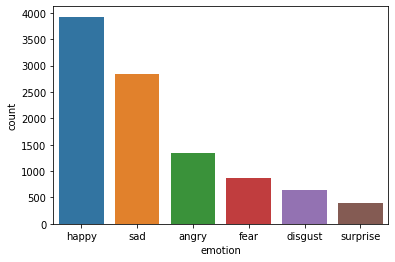

In [ ]:
# check distribution of the dataset
sns.countplot(df.emotion)
plt.show()


## dataset is imbalanced.

## Data Preprocessing

In [ ]:
!pip install emoji
import emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import emoji


stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
url = re.compile(r'https?://\S+|www\.\S+')

# # load unicodes for imoji
# with open("UNICODE_EMO.pickle", 'rb') as f:
#   UNICODE_EMO = pickle.load(f)
  

emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                          "]+", flags=re.UNICODE)


df['lower_cased'] = 0
df['punctuation_removed'] = 0
df['stopword_removed'] = 0
df['url_removed'] = 0
df['emoji_removed'] = 0
df['lemmetized'] = 0


# function to convert emojis to text
# def convert_emojis_to_text(s):
#   for emo in UNICODE_EMO:
#     new_s = re.sub(r'('+emo+')', "_".join(UNICODE_EMO[emo].replace(",", "").replace(":", "").split()), s)
#   return new_s


# function to do data preprocessing 
def data_preprocessing(df): 
  
  for i in range(df.shape[0]):
    # lower casing the data
    df['lower_cased'][i] = df['tweet'][i].lower()


    # remove url
    temp = df['lower_cased'][i]
    df['url_removed'][i] = url.sub("", temp)


    # remove the punctuation and numbers
    temp = df['url_removed'][i].translate(str.maketrans('', '', string.punctuation))
    df['punctuation_removed'][i] = " ".join([x for x in temp.split() if x.isalpha()])


    # remove emoji
    df['emoji_removed'][i] = emoji_pattern.sub(r'', df['punctuation_removed'][i])


    # remove stopwords
    temp = df['emoji_removed'][i].split()
    df['stopword_removed'][i] = " ".join([x for x in temp if x not in StopWords and x in dictionary_words and x is not None])


    # apply lemmatization
    temp = [word for word in df['stopword_removed'][i].split()] 
    temp = " ".join([lemmatizer.lemmatize(word) for word in temp])
    df['lemmetized'][i] = " ".join([word for word in temp.split() if len(word)> 2])


    if not df['lemmetized'][i] or len(df['lemmetized'][i].split()) < 4:
      df['lemmetized'][i] = np.nan


  return df[['tweet', 'lemmetized', 'emotion']]

In [ ]:
# call preprocessing
df_preprocessed = data_preprocessing(df)
df_preprocessed = df_preprocessed.rename(columns={'lemmetized': 'clean_tweet'})
print(df_preprocessed.shape)
df_preprocessed.head(10)

(10017, 3)


,tweet,clean_tweet,emotion
0,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",time ticking fast relive past happy joy face,happy
1,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",NaN,happy
2,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy birthday one hot love much amazing frien...,happy
3,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",best cheer left min cant save happy like treas...,happy
4,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",good morning wishing day filled sunshine happi...,happy
5,"#6: @Jeinalís Ramos ed ""Happy moments 🙏🏽 http...",NaN,happy
6,"#7: @Eric Rogers ed ""@CaitlinUnruh The movie ...",eric movie made happy several way think rely s...,happy
7,"#8: @Yanny Sandal ed ""I don’t give two shits ...",sandal give two met gala want twitter page see...,happy
8,"#9: @daynada ed ""my beautiful barbie bride an...",beautiful bride fixed dress aisle happy moment...,happy
9,"#10: @ß🌪 ed ""Someone Great has been one of th...",someone great one best chick romance hit reali...,happy


In [ ]:
df_preprocessed = df_preprocessed.dropna(subset=['clean_tweet'], how='any')
df_preprocessed.shape

(7716, 3)

In [ ]:
df_preprocessed.to_csv("preprocessed_emotion_dataset.csv", index=False)

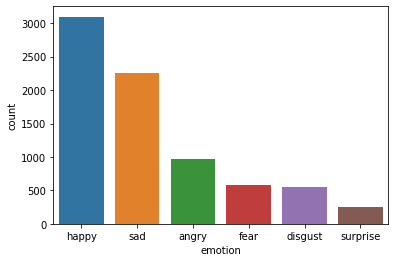

In [ ]:
sns.countplot(df_preprocessed.emotion)
plt.show()
